In [1]:
from numpy.random import Generator, PCG64
from numpy import unravel_index
import matplotlib.pyplot as plt
from copy import deepcopy
from random import sample
from enum import Enum
import pandas as pd
import numpy as np
import random 
random.seed(0)
import timeit
from operator import attrgetter
import math

In [2]:
import time
import multiprocessing as mp

# project packages
from models import SingleCustomer, LoadBalancer, Server, CustomerGroup, Status, Groups, ServerIDs, Statistics
from distributions import exponential_rng, homogeneous_poisson_process,\
homogeneous_poisson_process_variance_reduction

## Simulation
from simulation import handle_requests

## bootstrap
from bootstrap import bootstrap, moving_mean_var, test_bootstrap

## Scenario
from Scenario import Scenario

## utils -> get statistics
from utils import get_queue_statistics, get_statistics

## constants
from constants import MAX_CAPACITY, FIRST_ALLOCATION, SECOND_ALLOCATION

## Parameters for the simulations run: independent run, antithetic run
from SimulationParameters import SimulationParameters

## plot functions
from plot_functions import plot_queues, plot_empirical_mean_waiting_time

# Simulation

# First Run

The following two plots show the queue length over time, that is the number of users waiting, in the standard setting (without optimization).

In [3]:
def test_run(allocation: list, file_name: str):
    """
    Description:
        Run once the simulation
    Args:
        allocation (list) - The list of initial movies allocated to the ASNs
        file_name (str) - custom plot file name
    """
    scenario = Scenario(allocation, allocation)
    results, queues = handle_requests(scenario)
    statistics = get_statistics(results)
    plot_queues(queues, title=f'ASNs Movies Allocation: {allocation}', file_name=file_name)

MSN Customers Length: 5037    
ASN2 Customers Length: 1376   
ASN1 Customers Length: 2852   
4.256652976seconds to process all customers in three server


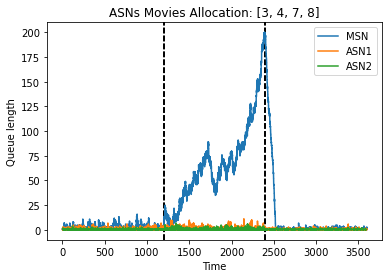

MSN Customers Length: 6150    
ASN2 Customers Length: 785    
ASN1 Customers Length: 2158   
7.4707252760000005seconds to process all customers in three server


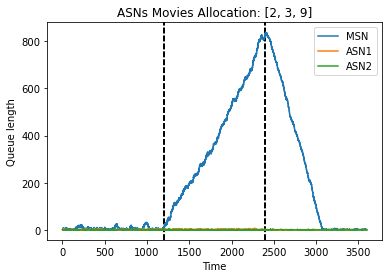

In [4]:
test_run(FIRST_ALLOCATION, file_name='first_allocation')
test_run(SECOND_ALLOCATION, file_name='second_allocation')

## Bootstraping

We are use bootstraping to improve our estimation of the true value. In this case we are applying the bootstrap technique to get a better estimation of the true mean waiting time.

In [5]:
#test_bootstrap(FIRST_ALLOCATION, file_name='first_allocation')  # UNCOMMENT LATER!
#test_bootstrap(SECOND_ALLOCATION, file_name='second_allocation')

## Variance Reduction

## 0. Independent Runs

In [6]:
def independent_runs(allocation: list):
    """
    Description:
        Parameters estimation, benchmark against antithetic runs and control variable
    Args:
        allocation (list) - The list of initial movies allocated to the ASNs
        file_name (str) - custom plot file name
    """
    t = 0
    scenario = Scenario(allocation, allocation)
    simulation_parameters = SimulationParameters()

    var = 0
    mean  = 0
    mean_waiting_time_all = []
    mean_waiting_time_mean_all = []
    mean_waiting_time_var_all = []
    while True: 
        t += 1

        # Run simulation
        results, _ = handle_requests(scenario)

        # Collect statistics
        statistics = get_statistics(results)


        mean_waiting_time = statistics['overall'][Statistics.mean.value]
        mean, var = moving_mean_var(
            mean_waiting_time,\
            mean,\
            var,\
            t
        )
  
        mean_waiting_time_all.append(mean_waiting_time)
        mean_waiting_time_mean_all .append(mean)
        mean_waiting_time_var_all.append(var)

        # Check if necessary precision reached
        if t >= simulation_parameters.run and np.sqrt(var / t) < simulation_parameters.precision:
            break
    
    return np.sqrt(mean_waiting_time_var_all)

## 1. Antithetic Runs

In [7]:
def antithetic_runs(allocation: list, scenario=None):
    t = 0
        # this is specified only if called from the optimization side
    if not scenario:
        scenario = Scenario(allocation, allocation)
    simulation_parameters = SimulationParameters()

    var = 0
    mean  = 0
    mean_waiting_time_all = []
    mean_waiting_time_mean_all = []
    mean_waiting_time_var_all = []
    
        
    #For optimization
    max_waiting_time = []
    average_waiting_time = []
    q75_waiting_time = []
    
    for i in np.arange(0, simulation_parameters.run/2): 
        t += 1

        # Run simulation (independent)
        u = np.random.rand(12, 15000)
        results, _ = handle_requests(scenario, u)


        # Run simulation (antithetic)
        u = 1 - u
        results_antithetic, _ = handle_requests(scenario, u)
        
        # Collect statistics
        statistics = get_statistics(results)
        statistics_antithetic = get_statistics(results_antithetic)
        ##################
        # For optimization
        ##################
        max_waiting_time.append(statistics['overall'][Statistics.max_.value])
        average_waiting_time = [statistics['overall'][Statistics.mean.value]]
        q75_waiting_time.append(statistics['overall'][Statistics.q75.value])
        mean_waiting_time = statistics['overall'][Statistics.mean.value]
        mean_waiting_time_antithetic = statistics_antithetic['overall'][Statistics.mean.value]
        
        mean_waiting_time = (mean_waiting_time + mean_waiting_time_antithetic) / 2
        mean, var = moving_mean_var(
            mean_waiting_time,\
            mean,\
            var,\
            t
        )

        mean_waiting_time_all.append(mean_waiting_time)
        mean_waiting_time_mean_all .append(mean)
        mean_waiting_time_var_all.append(var)
    # optimization
    statistics = dict()
    statistics['overall'] = dict()
    statistics['overall'][Statistics.mean.value] = np.mean(average_waiting_time)
    statistics['overall'][Statistics.max_.value] = np.mean(max_waiting_time)
    statistics['overall'][Statistics.q75.value] = np.mean(q75_waiting_time)
    
    return np.sqrt(mean_waiting_time_var_all), statistics

## 2. Controlled Mean

In [8]:
def controlled_mean(x, y, mu):
    """ Calculates the controlled mean.
    
    Keywords:
        x (array): Data.
        y (array): Control data.
        mu (float): Scalar expectation of the control data.
    
    Returns:
        avg (float): Controlled mean of the data.
        var (float): Variance of the controlled mean.
        z (array): Optimal linear combination of the data and the control data. 
    """

    cov = np.cov(x, y)
    cov_xy = cov[1, 0]
    var_y = cov[1, 1]
    
    c = -cov_xy / var_y
    z = x + c * (y - mu)
    
    avg = z.mean()
    var = z.var()
    
    return avg, var, z

In [9]:
def control_variate_runs(allocation: list, scenario=None):
    t = 0
    
    # this is specified only if called from the optimization side
    if not scenario:
        scenario = Scenario(allocation, allocation)
    simulation_parameters = SimulationParameters()
    
    var = 0
    mean  = 0
    mean_waiting_time_all = []
    mean_waiting_time_mean_all = []
    mean_waiting_time_var_all = []
    
    
    max_queue_length_all = []
    mean_waiting_time_control_all = []
    
    
    #For optimization
    max_waiting_time = []
    average_waiting_time = []
    q75_waiting_time = []
    
    #Main loop
    for j in np.arange(simulation_parameters.run):
        t += 1

        # Run simulation
        results, queue = handle_requests(scenario)
        # the maximum queue length for each group
        queue = get_queue_statistics(queue)
        # Collect statistics
        statistics = get_statistics(results)
        
        
        ##################
        # For optimization
        ##################
        max_waiting_time.append(statistics['overall'][Statistics.max_.value])
        average_waiting_time = [statistics['overall'][Statistics.mean.value]]
        q75_waiting_time.append(statistics['overall'][Statistics.q75.value])
        
        mean_waiting_time = statistics['overall'][Statistics.mean.value]
        mean, var = moving_mean_var(
            mean_waiting_time,\
            mean,\
            var,\
            t
        )
  
        mean_waiting_time_all.append(mean_waiting_time)
        mean_waiting_time_mean_all .append(mean)
        mean_waiting_time_var_all.append(var)
        
        mean_queue_length = (queue['overall']['max'] + queue['overall']['min']) / 2
        # Control the average waiting time
        if j:
            max_queue_length_all.append(mean_queue_length)
            _, var_control, _ = controlled_mean(
                np.array(mean_waiting_time_all),
                np.array(max_queue_length_all),
                0.5
            )
            mean_waiting_time_control_all.append(var_control)
        else:
            max_queue_length_all = [mean_queue_length]
            mean_waiting_time_control_all = [var]

    print(f'Correlation Matrix')
    print(f'{np.corrcoef(max_queue_length_all, mean_waiting_time_all)}')
    
    # optimization
    statistics = dict()
    statistics['overall'] = dict()
    statistics['overall'][Statistics.mean.value] = np.mean(average_waiting_time)
    statistics['overall'][Statistics.max_.value] = np.mean(max_waiting_time)
    statistics['overall'][Statistics.q75.value] = np.mean(q75_waiting_time)
    
    return np.sqrt(mean_waiting_time_var_all), statistics

In [10]:
# independent = independent_runs(FIRST_ALLOCATION)
# antithetic = antithetic_runs(FIRST_ALLOCATION)

In [11]:
# control_variate, _ = control_variate_runs(FIRST_ALLOCATION)

In [12]:
import matplotlib.pyplot as plt

In [13]:
# fig = plt.figure()
# ax = plt.subplot(1,1,1)

# ax.plot(independent, label='Std. dev. - independent runs')
# ax.plot(np.arange(0,len(independent),step=2), antithetic, label='Std. dev.- antithetic runs')
# ax.plot(control_variate, label='Std. dev. - control variate runs')
# ax.set(title='Waiting Time',
#        xlabel='Epoch',
#        ylabel='Average Waiting Time')
# ax.legend()
# fig.savefig('variance_reduction.pdf', dpi=300)
# plt.show()

# Optimization Part
------------------------------------------------------------

## 1. Solution Representation
--------------------------------

In [14]:
class Solution():
    
    """
    This class provides the solution representation which
    consists of two lists: one for the movies assigned to
    ASN 1 and one for the movies assigned to ASN 2. In this
    class we also keep the performance metrics associated
    with our solution representation. We have two different
    performance metrics:
        i)  Waiting time of clients
            --> in the form of the desired statistic (average, max, or q75)
        ii) Total size in MB used in ASN 1 and ASN 2
    """
    
    def __init__(self, movies_ASN1, movies_ASN2, wt_obj):
        
        """
        % Constructor
        
        @inputs:
        --------
        
        --> movies_ASN1: list, movies stored in ASN 1
        --> movies_ASN2: list, movies stored in ASN 2
        --> wt_obj: string, the desired waiting time statistic (average, max, or q75)
        """
        
        self.movies_ASN1 = movies_ASN1  
        self.movies_ASN2 = movies_ASN2
        self.scenario = Scenario(self.movies_ASN1, self.movies_ASN2)  # the link with the simulation part
        self.total_size = sum([self.scenario.movie_sizes[i] for i in self.movies_ASN1])
        self.total_size += sum([self.scenario.movie_sizes[i] for i in self.movies_ASN2])
        
        # Yoooooooooo, that's a lot!
        _, self.statistics = antithetic_runs(
            allocation=self.movies_ASN1, # dummy variable if scenario is specified
            scenario=self.scenario # for compatibility between simulation and optimization
        ) 
        
        self.wt_obj = wt_obj
        self.waiting_time = self.statistics['overall'][self.wt_obj]  # desired statistic
        
        # let's keep all statistics (average, max, 75) associated with the solution
        self.waiting_time_max = self.statistics['overall']['max']
        self.waiting_time_q75 = self.statistics['overall']['q75']
        self.waiting_time_average = self.statistics['overall']['average']

    def get_objectives(self):
        
        """
        % Returns the performance metrics we have.
        
        @inputs:
        --------
        
        --> None
        
        @outputs:
        ---------
        
        --> a tuple of two elements.
        
        Warning: 
        -------
        The second performance metric (objective), i.e.,
        total size, is only used in multi-objective opt.
        """
        
        return self.waiting_time, self.total_size
    
    def set_movies_ASN1(self, new_movies):
        
        """
        % It overrides the list of movies
        assigned to storage node ASN 1
        
        @inputs:
        --------
        
        --> new movies: list, new movies to stored in ASN 1
        
        @outputs:
        ---------
        
        --> %inplace%
        """
        
        self.movies_ASN1 = new_movies
    
    def set_movies_ASN2(self, new_movies):
        
        """
        % It overrides the list of movies
        assigned to storage node ASN 2
        
        @inputs:
        --------
        
        --> new movies: list, new movies to stored in ASN 2
        
        @outputs:
        ---------
        
        --> %inplace%
        """
        
        self.movies_ASN2 = new_movies
    
    def change_wt_obj(self, new_wt_obj):
        
        """
        % It changes the desired statistic of waiting time
        as given in the argument.
        
        @inputs:
        --------
        
        --> new_wt_obj: string, ("average", "max", or "q75")
        
        @outputs:
        ---------
        
        --> %inplace%
        """
        
        self.wt_obj = new_wt_obj
        self.waiting_time = self.statistics['overall'][self.wt_obj]

## 2. Initial Solution
----------------------------------------

In [15]:
def get_min_size_left(movie_ls):
    
    """
    % It returns the minimum movie size of the movies
    which are not placed in the given list of the movies
    as an argument.
    
    @inputs:
    --------
    
    --> movie_ls: list, list of movies
    
    @outputs:
    ---------
    
    --> integer
    """
    
    scenario = Scenario([], [])  # null scenario to reach some problem parameters (like movie sizes)
    left_movies = list(set(list(range(10))) - set(movie_ls))  # list of movies that are not placed
    return min([scenario.movie_sizes[i] for i in left_movies])  # the minimum size among them

def constructionHeuristic(wt_obj):
    
    """
    % This function applies a construction heuristic which tries to 
    assign most popular film-group combinations to appropriate servers
    considering the distance between selected groups and servers.
    
    @inputs:
    --------
    
    --> wt_obj: string, ("average", "max", or "q75")
    
    @outputs:
    ---------
    
    --> Solution object
    """
    
    movies1, movies2 = [], []
    size1, size2 = 0, 0 
    scenario = Scenario(movies1, movies2)
    popularity = np.array(deepcopy(scenario.popularities))
    while True:
        group_, movie_ = unravel_index(popularity.argmax(), popularity.shape)
        if popularity[group_, movie_]<0:  # it means that we examined all group-movie pairs.
            break                         # therefore, we can terminate the loop
        popularity[group_, movie_] = - 1  # not to draw the same argmax indexes again and again
        group_obj = None
        if group_ == 0:
            group_obj = CustomerGroup(Groups.Group_1.value, scenario.popularities[0],
                                      scenario.activity_patterns[0], scenario.distances_g1)
        elif group_ == 1:
            group_obj = CustomerGroup(Groups.Group_2.value, scenario.popularities[1],
                                      scenario.activity_patterns[1], scenario.distances_g2)
        elif group_ == 2:
            group_obj = CustomerGroup(Groups.Group_3.value, scenario.popularities[2],
                                      scenario.activity_patterns[2], scenario.distances_g3)
        best_server = group_obj.best_server_options()[0]  # find the best server considering the distances
        if best_server == 'ASN1' and size1+scenario.movie_sizes[movie_] <= 3500 and movie_ not in movies1:
            movies1.append(movie_)
            size1 += scenario.movie_sizes[movie_]
        if best_server == 'ASN2' and size2+scenario.movie_sizes[movie_] <= 3500 and movie_ not in movies2:
            movies2.append(movie_)
            size2 += scenario.movie_sizes[movie_]
        # let's check that it is still possible to insert a film without violating feasibility
        if size1+get_min_size_left(movies1)>3500 and size2+get_min_size_left(movies2)>3500:
            break
    return Solution(movies1, movies2, wt_obj)

def getRandomFeasibleSolution(wt_obj):
    
    """
    % Generates a random feasible solution
    
    @inputs:
    --------
    
    --> wt_obj: string, ("average", "max", or "q75")
    
    @outputs:
    ---------
    
    --> Solution object
    """
    
    movies1, movies2 = [], []
    size1, size2 = 0, 0 
    scenario = Scenario(movies1, movies2)
    while True:
        rand_ = random.uniform(0,1)  # to determine which ASN will be considered in the current iteration
        if rand_<=0.5:  # ASN 1
            movie_ = random.choice(list(set(list(range(10))) - set(movies1)))  # random movie for ASN 1
            if size1+scenario.movie_sizes[movie_]<=3500:
                movies1.append(movie_)
                size1 += scenario.movie_sizes[movie_]
        else:
            movie_ = random.choice(list(set(list(range(10))) - set(movies2)))  # random movie for ASN 2 
            if size2+scenario.movie_sizes[movie_]<=3500:
                movies2.append(movie_)
                size2 += scenario.movie_sizes[movie_]
        # let's check that it is still possible to insert a film without violating feasibility
        if size1+get_min_size_left(movies1)>3500 and size2+get_min_size_left(movies2)>3500:
            break
    return Solution(movies1, movies2, wt_obj)

## 3. Neighborhood Definitions
----------------------------------

In [16]:
def generateNewMovie_1(rg, movie_list):
    #From the starting point, randomly choose 1 movie to delete, 
    #Randomly choose 2, check size
    movie_sizes = [850,950,1000,1200,800,900,1000,750,700,1100]

    new_movie_list = movie_list.copy() # make a copy 
    n_new_movie = len(new_movie_list)
    n_movies = 10
    #delete
    c1 = rg.choice(range(0, n_new_movie))
    del new_movie_list[c1]

    # choose another two
    c1 = -1
    c2 = -1
    
    while ((c1 == -1) or (c2 == -1) or (c1 == c2) or (c1 in movie_list) or (c2 in movie_list)):
        c1 = int(np.floor(rg.random() * n_movies))
        c2 = int(np.floor(rg.random() * n_movies))
    
    # check size
    sum_movie_size = 0
    for i in new_movie_list:
        sum_movie_size += movie_sizes[i]
    if sum_movie_size + movie_sizes[c1] <= 3500:
        new_movie_list.append(c1)
        sum_movie_size += movie_sizes[c1]
        if sum_movie_size + movie_sizes[c2] <= 3500:
            new_movie_list.append(c2)
            
    else: 
        if sum_movie_size + movie_sizes[c2] <= 3500:
            new_movie_list.append(c2)

    new_movie_list.sort()
    return new_movie_list

def get_neighbor_1(rg, current_sol):
    
    """
    % It generates the candidate solution given solution in the arguments
    by using the function "generateNewMovie_1"
    
    @ outputs:
    ----------
    Solution object
    """
    
    movies_1, movies_2 = current_sol.movies_ASN1, current_sol.movies_ASN2
    new_movies_1 = generateNewMovie_1(rg, movies_1)
    new_movies_2 = generateNewMovie_1(rg, movies_2)
    return Solution(new_movies_1, new_movies_2, current_sol.wt_obj)   

In [17]:
def generateNewMovie_2(rg, movie_list):
    #From the starting point, randomly choose 2 movies to delete, 
    #Randomly choose 3, check size
    movie_sizes = [850,950,1000,1200,800,900,1000,750,700,1100]

    new_movie_list = movie_list.copy() # make a copy 
    n_new_movie = len(new_movie_list)
    n_movies = 10
    #delete
    c1 = rg.choice(range(0, n_new_movie))
    if n_new_movie > 1:
        c2 = rg.choice(range(0, n_new_movie))
        while (c2 == c1):
            c2 = rg.choice(range(0, n_new_movie))
        if c2 > c1:
            del new_movie_list[c2]
            del new_movie_list[c1]
        else:
            del new_movie_list[c1]
            del new_movie_list[c2]

    # choose another three
    c1 = -1
    c2 = -1
    c3 = -1
    while ((c1 == -1) or (c2 == -1) or (c3 == -1)
        or (c1 == c2) or (c1 == c3) or (c2 == c3)
        or (c1 in movie_list) or (c2 in movie_list) or (c3 in movie_list)):
        c1 = int(np.floor(rg.random() * n_movies))
        c2 = int(np.floor(rg.random() * n_movies))
        c3 = int(np.floor(rg.random() * n_movies))
    
    # check size
    sum_movie_size = 0
    for i in new_movie_list:
        sum_movie_size += movie_sizes[i]
    if sum_movie_size + movie_sizes[c1] <= 3500:
        new_movie_list.append(c1)
        sum_movie_size += movie_sizes[c1]
        if sum_movie_size + movie_sizes[c2] <= 3500:
            new_movie_list.append(c2)
            sum_movie_size += movie_sizes[c2]
            if sum_movie_size + movie_sizes[c3] <= 3500:
                new_movie_list.append(c3)
    else: 
        if sum_movie_size + movie_sizes[c2] <= 3500:
            new_movie_list.append(c2)
            sum_movie_size += movie_sizes[c2]
            if sum_movie_size + movie_sizes[c3] <= 3500:
                new_movie_list.append(c3)
        else:
            if sum_movie_size + movie_sizes[c3] <= 3500:
                new_movie_list.append(c3)

    new_movie_list.sort()
    return new_movie_list

def get_neighbor_2(rg, current_sol):
    
    """
    % It generates the candidate solution given solution in the arguments
    by using the function "generateNewMovie_2"
    
    @ outputs:
    ----------
    Solution object
    """
    
    movies_1, movies_2 = current_sol.movies_ASN1, current_sol.movies_ASN2
    new_movies_1 = generateNewMovie_2(rg, movies_1)
    new_movies_2 = generateNewMovie_2(rg, movies_2)
    return Solution(new_movies_1, new_movies_2, current_sol.wt_obj)   

In [18]:
def generateNewMovie_3(rg, movie_list):
    #From the starting point, randomly choose 3 movies to delete, 
    #Randomly choose 4, check size
    movie_sizes = [850,950,1000,1200,800,900,1000,750,700,1100]

    new_movie_list = movie_list.copy() # make a copy 
    n_new_movie = len(new_movie_list)
    n_movies = 10
    #delete
    c1 = rg.choice(range(0, n_new_movie))
    if n_new_movie > 1:
        c2 = rg.choice(range(0, n_new_movie))
        while (c2 == c1):
            c2 = rg.choice(range(0, n_new_movie))
    
        if n_new_movie > 2:
            c3 = rg.choice(range(0, n_new_movie))
            while ((c3 == c1) or (c3 == c2)):
                c3 = rg.choice(range(0, n_new_movie))
        
            for ele in sorted([c1,c2,c3], reverse = True): 
                del new_movie_list[ele]
        else:
            if c2 > c1:
                del new_movie_list[c2]
                del new_movie_list[c1]
            else:
                del new_movie_list[c1]
                del new_movie_list[c2]

    # choose another four
    c1 = -1
    c2 = -1
    c3 = -1
    c4 = -1
    while ((c1 == -1) or (c2 == -1) or (c3 == -1) or (c4 == -1)
        or (c1 == c2) or (c1 == c3) or (c2 == c3) or (c1 == c4) or (c2  == c4) or (c3 == c4)
        or (c1 in movie_list) or (c2 in movie_list) or (c3 in movie_list) or (c4 in movie_list)):
        c1 = int(np.floor(rg.random() * n_movies))
        c2 = int(np.floor(rg.random() * n_movies))
        c3 = int(np.floor(rg.random() * n_movies))
        c4 = int(np.floor(rg.random() * n_movies))
    
    # check size
    sum_movie_size = 0
    for i in new_movie_list:
        sum_movie_size += movie_sizes[i]
    if sum_movie_size + movie_sizes[c1] <= 3500:
        new_movie_list.append(c1)
        sum_movie_size += movie_sizes[c1]
        if sum_movie_size + movie_sizes[c2] <= 3500:
            new_movie_list.append(c2)
            sum_movie_size += movie_sizes[c2]
            if sum_movie_size + movie_sizes[c3] <= 3500:
                new_movie_list.append(c3)
                sum_movie_size += movie_sizes[c3]
                if sum_movie_size + movie_sizes[c4] <= 3500:
                    new_movie_list.append(c4)
    else: 
        if sum_movie_size + movie_sizes[c2] <= 3500:
            new_movie_list.append(c2)
            sum_movie_size += movie_sizes[c2]
            if sum_movie_size + movie_sizes[c3] <= 3500:
                new_movie_list.append(c3)
                sum_movie_size += movie_sizes[c3]
                if sum_movie_size + movie_sizes[c4] <= 3500:
                    new_movie_list.append(c4)
        else:
            if sum_movie_size + movie_sizes[c3] <= 3500:
                new_movie_list.append(c3)
                sum_movie_size += movie_sizes[c3]
                if sum_movie_size + movie_sizes[c4] <= 3500:
                    new_movie_list.append(c4)
            else:
                if sum_movie_size + movie_sizes[c4] <= 3500:
                    new_movie_list.append(c4)

    new_movie_list.sort()
    return new_movie_list

def get_neighbor_3(rg, current_sol):
    
    """
    % It generates the candidate solution given solution in the arguments
    by using the function "generateNewMovie_3"
    
    @ outputs:
    ----------
    Solution object
    """
    
    movies_1, movies_2 = current_sol.movies_ASN1, current_sol.movies_ASN2
    new_movies_1 = generateNewMovie_3(rg, movies_1)
    new_movies_2 = generateNewMovie_3(rg, movies_2)
    return Solution(new_movies_1, new_movies_2, current_sol.wt_obj)   

In [19]:
def binary_change(movie_list, i):
    
    """
    % Checks whether given movie is placed in the given
    movie list or not. If given remove it, otherwise adds it 
    unless it does not violate the feasibility (capacity constraint).
    
    @Input:
    -------
    movie_list: List, movie lists
    i: int, specific movie
    movie_sizes: dict
    
    @Output:
    --------
    A list
    """
    movie_sizes = [850,950,1000,1200,800,900,1000,750,700,1100]
    new_movie_list = deepcopy(movie_list)
    if i in new_movie_list:
        new_movie_list.remove(i)
    else:
        new_movie_list.append(i)
    
    if sum([movie_sizes[movie] for movie in new_movie_list]) > 3500:
        return movie_list
    else:
        return new_movie_list

def get_neighbor_4(rg, current_sol):
    
    """
    % It generates the candidate solution given solution in the arguments
    by using the function "generateNewMovie_4"
    
    @ outputs:
    ----------
    Solution object
    """
    movie_1, movie_2 = current_sol.movies_ASN1, current_sol.movies_ASN2
    sample1 = random.sample(movie_2, min(len(movie_2), 2))
    sample2 = random.sample(movie_1, min(len(movie_1), 2))
    best_neighbor, best_neighbor_val = None, np.inf
    for i in sample1:
        new_movie_1 = binary_change(movie_1, i)
        for j in sample2:
            new_movie_2 = binary_change(movie_2, j)
            candidate = Solution(new_movie_1, new_movie_2, current_sol.wt_obj)
            candidate_val, _ = candidate.get_objectives()
            if candidate_val < best_neighbor_val:
                best_neighbor, best_neighbor_val = candidate, candidate_val
    if best_neighbor is not None:
        return best_neighbor
    else:
        return current_sol

## 4. Single objective
------------------------------------------------------------------------------------------------------------------

### 4.1. Helpers

In [20]:
def temperature_update(init, i, iterations):
        """
        % It returns an updated version of the 
        temperature value
        
        @inputs:
        --------
        --> init: float, initial temperature value
        --> i: int, current iterations number
        --> iterations: int, total number of iterations
        
        @outputs:
        ---------
        --> updated temperature value, float
        """
        p_0 = 0.999
        p_f = 0.001
        return -init/np.log(p_0+(p_f-p_0)/iterations*i)

In [21]:
def get_candidate_solution(rg, given_solution, which_neighbor):
    """
    % It generates a neighborhood of the given solution with respect to
      the desired neighborhood definition.
      
    @inputs:
    --------
    rg: random number generator
    given solution: Solution object, current solution
    which_neighbor: int, desired neighborhood definition
                    1 --> neighborhood definition 1
                    2 --> neighborhood definition 2
                    3 --> neighborhood definition 3
                    4 --> neighborhood definition 4
    wt_obj: string, ("average", "max", or "q75")
    
    @output:
    --------
    Solution object, neighborhood solution
    """
    
    if which_neighbor == 1:
        return get_neighbor_1(rg, given_solution)
    elif which_neighbor == 2:
        return get_neighbor_2(rg, given_solution)
    elif which_neighbor == 3:
        return get_neighbor_3(rg, given_solution)
    elif which_neighbor == 4:
        return get_neighbor_4(rg, given_solution)
    else:
        raise ValueError("Should be 1,2,3, or 4!")

### 4.2. Base Class

In [22]:
class AlgorithmSingleObjective(object):

    """
    This class provides basis for the
    algorithms used in  single-obj 
    optimization part. 
    """
    
    def __init__(self, rg, initial_solution, n_iteration, wt_obj):
        
        """
        % Constructor function
        
        @inputs:
        --------
        --> rg: random number generator
        --> initial_solution: Solution object, the initial solution to initiate search
        --> n_iteration: int, the maximum number of iterations for our algorithms
        --> wt_obj: string, ("average", "max", or "q75")
        """
        
        self.rg = rg  
        self.initial_solution = initial_solution
        self.n_iteration = n_iteration
        self.wt_obj = wt_obj    
        self.best_solution = deepcopy(self.initial_solution)
        self.best_value, _ = self.initial_solution.get_objectives()
        self.algorithm_name = None
        self.time = None
        
        self.history_bestsol = []      # keeps track of best solutions over the iterations
        self.history_currentsol = []   # keeps track of current solutions over the iterations
        self.history_candidatesol = [] # keeps track of candidate solutions over the iterations
        
        # keep all statistics associated with the best found solution
        self.best_value_max = None
        self.best_value_average = None
        self.best_value_q75 = None
        # the three statistics above will be updated once the algorithm
        # returns its best found solution

### 4.3. Local Search

In [23]:
class LocalSearch(AlgorithmSingleObjective):
    
    """
    Inherited from AlgorithmSingleObjective class to implement Local Search
    """
    
    def __init__(self, rg, initial_solution, n_iteration, wt_obj):
        
        """
        % constructor
        
        @Inputs:
        --------
        
        --> rg: random number generator
        --> initial_solution: Solution object, initial solution for heuristics
        --> n_iteration: int, maximum number of iterations allowed
        --> wt_obj: string, ("average", "max", or "q75")
        """
        
        AlgorithmSingleObjective.__init__(self, rg, initial_solution, n_iteration, wt_obj)
        self.algorithm_name = "LocalSearch"
    
    def run(self, which_neighbor):
        
        """
        Runs the local search algorithm considering the given neighborhood definition
        
        @inputs:
        -------
        
        --> which_neighbor: int, 1,2,3, or 4
        
        @outputs:
        ---------
        
        --> %inplace% 
        """
        start_time = timeit.default_timer()
        for i in range(self.n_iteration):
            print('iteration ', i+1)
            candidate_solution = get_candidate_solution(self.rg, self.best_solution, which_neighbor)
            candidate_value, _ = candidate_solution.get_objectives()
            self.history_candidatesol.append(candidate_value)
            if candidate_value < self.best_value:
                self.best_solution = candidate_solution
                self.best_value = candidate_value
            self.history_bestsol.append(self.best_value)
        end_time = timeit.default_timer()
        self.time = end_time - start_time
        self.best_value_max = self.best_solution.waiting_time_max
        self.best_value_average = self.best_solution.waiting_time_average
        self.best_value_q75 = self.best_solution.waiting_time_q75
    
    def plot_ls(self, which_neighbor, which_run=None, randomm_init_sol=False):
      
        """
        Plots the history of local search.
        """
        iterations = list(range(1, self.n_iteration+1))
        fig,ax = plt.subplots(figsize=(12,7))
        ax.set_xlabel("Iteration Number", fontsize=12)
        ax.set_ylabel("Candidate Solution Objective Function Value", fontsize=12)
        ax.set_xticks(list(range(1, self.n_iteration+1)))
        ax2 = ax.twinx()
        ax.plot(iterations, self.history_candidatesol, color='blue', label='Candidate Solution', marker='o')
        ax2.plot(iterations, self.history_bestsol, color='red', label='Best Solution',marker='o')
        ax.legend(loc='upper left')
        ax2.legend(loc='upper right')
        ax2.set_ylabel("Best Solution Objective Function Value", fontsize=12)
        if randomm_init_sol is False:
            title_ = "Local Search with Neighborhood Definition " + str(which_neighbor)
        else:
            title_ = "Local Search with Neighborhood Definition " + str(which_neighbor) + " & Random Initial Solution"
        plt.title(title_, fontsize=16)
        dir_ = "plots/optimization/local_search_experiment/"
        if randomm_init_sol is False:
            if which_run is None:
                dir_ += "ls_" + str(which_neighbor) + ".pdf"
            else:
                dir_ += "ls_" + str(which_neighbor) + "_" + str(which_run) + ".pdf"
        else:
            if which_run is None:
                dir_ += "rnd_ls_" + str(which_neighbor) + ".pdf"
            else:
                dir_ += "rnd_ls_" + str(which_neighbor) + "_" + str(which_run) + ".pdf"
        plt.savefig(dir_)

### 4.4. Simulated Annealing

In [24]:
class SimulatedAnnealing(AlgorithmSingleObjective):
    
    """
    Inherited from AlgorithmSingleObjective class to implement Simulated Annealing
    """
    def __init__(self, rg, initial_solution, n_iteration, wt_obj, temp_init=1):
        
        """
        % constructor function
        
        @Inputs:
        --------
        
        --> rg: random number generator
        --> initial_solution: Solution object, initial solution for heuristics
        --> n_iteration: int, maximum number of iterations allowed
        --> wt_obj: string, ("average", "max", or "q75")
        --> temp_init: float (optinal), initial temperature value
        """
        AlgorithmSingleObjective.__init__(self, rg, initial_solution, n_iteration, wt_obj)
        self.temp_init = temp_init
        self.algorithm_name = "SimulatedAnnealing"
    
    def run(self, which_neighbor):
        
        """
        Runs the simulated annealing algorithm considering the given neighborhood definition
        
        @inputs:
        -------
        
        --> which_neighbor: int, 1,2,3, or 4
        
        @outputs:
        ---------
        
        --> %inplace% 
        """
        
        start_time = timeit.default_timer()
        current_solution = deepcopy(self.initial_solution)
        for i in range(self.n_iteration):
            # print('iteration ', i+1)
            candidate_solution = get_candidate_solution(self.rg, current_solution, which_neighbor)
            candidate_value, _ = candidate_solution.get_objectives()
            self.history_candidatesol.append(candidate_value)
            current_temperature = temperature_update(self.temp_init, i, self.n_iteration)
            diff = candidate_value - self.best_value
            
            if diff<0:  # then update both best found solution and the current solution
                current_solution = deepcopy(candidate_solution)
                self.best_solution = deepcopy(candidate_solution)
                self.best_value = candidate_value
            else:
                if self.rg.random() < np.exp(-diff/current_temperature):  # then only update the current solution
                    current_solution = deepcopy(candidate_solution)
            self.history_bestsol.append(self.best_value)
            self.history_currentsol.append(current_solution.get_objectives()[0])
        end_time = timeit.default_timer()
        self.time = end_time - start_time
        self.best_value_max = self.best_solution.waiting_time_max
        self.best_value_average = self.best_solution.waiting_time_average
        self.best_value_q75 = self.best_solution.waiting_time_q75
        
    def plot_sa(self, which_neighbor, which_run=None, randomm_init_sol=False):
        """
        Plots the history of simulated annealing.
        """
        
        iterations = list(range(1, self.n_iteration+1))
        fig,ax = plt.subplots(figsize=(12,7))
        ax.set_xlabel("Iteration Number", fontsize=12)
        ax.set_ylabel("Objective Function Value", fontsize=12)
        ax.set_xticks(list(range(1, self.n_iteration+1)))
        ax2 = ax.twinx()
        ax.plot(iterations, self.history_candidatesol, color='blue', label='Candidate Solution', marker='o')
        ax.plot(iterations, self.history_currentsol, color='green', label='Current Solution', marker='o')
        ax2.plot(iterations, self.history_bestsol, color='red', label='Best Solution',marker='o')
        ax.legend(loc='upper left')
        ax2.legend(loc='upper right')
        ax2.set_ylabel("Best Solution Objective Function Value", fontsize=12)
        if randomm_init_sol is False:
            title_ = "Simulated Annealing with Neighborhood Definition " + str(which_neighbor)
        else:
            title_ = "Simulated Annealing with Neighborhood Definition " + str(which_neighbor) + " & Random Initial Solution"
        plt.title(title_, fontsize=16)
        dir_ = "plots/optimization/simulated_annealing_experiment/"
        if randomm_init_sol is False:
            if which_run is None:
                dir_ += "sa_" + str(which_neighbor) + ".pdf"
            else:
                dir_ += "sa_" + str(which_neighbor) + "_" + str(which_run) + ".pdf"
        else:
            if which_run is None:
                dir_ += "rnd_sa_" + str(which_neighbor) + ".pdf"
            else:
                dir_ += "rnd_sa_" + str(which_neighbor) + "_" + str(which_run) + ".pdf"
        plt.savefig(dir_)


### 4.5. Variable Neighborhood Search (VNS)

In [25]:
class VNS(AlgorithmSingleObjective):
    """
    Inherited from AlgorithmSingleObjective class to implement Variable Neighborhood Search
    """
    
    def __init__(self, rg, initial_solution, n_iteration, wt_obj, k_neighborhoodStrategy=4):
        """
        % constructor function
        
        @Inputs:
        --------
        
        --> rg: random number generator
        --> initial_solution: Solution object, initial solution for heuristics
        --> n_iteration: int, maximum number of iterations allowed
        --> wt_obj: string, ("average", "max", or "q75")
        --> k_neighborhoodStrategy: int (optinal)
        """
        
        AlgorithmSingleObjective.__init__(self, rg, initial_solution, n_iteration, wt_obj)
        self.k_neighborhoodStrategy = k_neighborhoodStrategy
        self.algorithm_name = "VNS"
        self.history_k = []
    
    def run(self):
        """
        % Runs VNS
        """
        
        n_iter = 0
        k = 1
        start_time = timeit.default_timer()
        while n_iter < self.n_iteration:
            while True:
                # print('iter: ', n_iter, 'k', k)
                best_candidate = get_candidate_solution(self.rg, self.best_solution, k)
                best_candidate_val,_ = best_candidate.get_objectives()
                n_iter +=1
                self.history_candidatesol.append(best_candidate_val)
                self.history_k.append(k)
                if best_candidate_val < self.best_value:
                    self.best_solution = best_candidate
                    self.best_value = best_candidate_val
                    self.history_bestsol.append(self.best_value)
                else:
                    self.history_bestsol.append(self.best_value)
                    break
                if n_iter >= self.n_iteration:
                    break
            k += 1
            if k == self.k_neighborhoodStrategy+1:
                k = 1  # ***
        # *** We let the algorithm to return the first neighborhood definition unless 
        # it reaches to the maximum number of iterations, as it allows us to increase
        # the level of diversification by including randomness.
        end_time = timeit.default_timer()
        self.time = end_time - start_time
        self.best_value_max = self.best_solution.waiting_time_max
        self.best_value_average = self.best_solution.waiting_time_average
        self.best_value_q75 = self.best_solution.waiting_time_q75
                
    def plot_vns(self, which_run=None, randomm_init_sol=False):
        
        """
        Plots the history of VNS.
        """
        
        iterations = list(range(1, self.n_iteration+1))
        fig,ax = plt.subplots(figsize=(12,7))
        ax.set_xlabel("Iteration Number", fontsize=12)
        ax.set_ylabel("Objective Function Value", fontsize=12)
        ax.set_xticks(list(range(1, self.n_iteration+1)))
        ax2 = ax.twinx()
        ax.plot(iterations, self.history_candidatesol, color='blue', label='Candidate Solution', marker='o')
        ax2.plot(iterations, self.history_bestsol, color='red', label='Best Solution',marker='o')
        ax.legend(loc='upper left')
        ax2.legend(loc='upper right')
        ax2.set_ylabel("Best Solution Objective Function Value", fontsize=12)
        if randomm_init_sol is False:
            title_ = "VNS"
        else:
            title_ = "VNS with Random Initial Solution"

        plt.title(title_, fontsize=16)
        dir_ = "plots/optimization/vns_experiment/"
        
        
        if randomm_init_sol is False:
            if which_run is None:
                dir_ += "vns.pdf"
            else:
                dir_ += "vns_" + str(which_run) + ".pdf"
        else:
            if which_run is None:
                dir_ += "rnd_vns.pdf"
            else:
                dir_ += "rnd_vns_" + str(which_run) + ".pdf"
            
        plt.savefig(dir_)

## 5.Multi-objective Optimization
--------------------------------------------------------------------------------------------

### 5.1. Helpers

In [26]:
# Pareto dominance
def improvement(solution_old, solution_new):
    
    """
    % It checks whether new solution dominates
    the old solution or not
    
    @inputs:
    --------
    --> solution_old: Solution object, old solution
    --> solution_new: Solution object, new solution
    
    @outputs:
    --------
    --> true if new solution dominates; false, otherwise
    """
    rule_1, rule_2 = False, False
    
    waiting_time_old, total_size_old = solution_old.get_objectives()
    waiting_time_new, total_size_new = solution_new.get_objectives()
    
    if waiting_time_new <= waiting_time_old and total_size_new <= total_size_old:
        rule_1 = True
        
    if waiting_time_new < waiting_time_old or total_size_new < total_size_old:
        rule_2 = True

    return rule_1 and rule_2

### 5.2. Base Class

In [27]:
class AlgorithmMultiObjective(object):

    """
    This class provides basis for the
    algorithms used in  multi-obj 
    optimization part. 
    """
    
    def __init__(self, rg, initial_solution, n_iteration, wt_obj):
        
        """
        % Constructor function
        
        @inputs:
        --------
        --> rg: random number generator
        --> initial_solution: Solution object, the initial solution to initiate local search
        --> n_iteration: int, the maximum number of iterations for our algorithms
        --> wt_obj: string, ("average", "max", or "q75")
        """
        
        self.rg = rg  
        self.initial_solution = initial_solution
        self.n_iteration = n_iteration
        self.wt_obj = wt_obj    
        
        self.algorithm_name = None
        self.time = None
        
        self.pareto_frontier = [deepcopy(self.initial_solution)]
        self.considered = []
        self.removed = []
        
    def plot(self, which_neighbor=None, which_run=None):
        """
        % plots history of multi-objective optimization algorithm
        """
        plt.figure(figsize=(12,7))
        plt.scatter([sol.total_size for sol in self.considered],
                    [sol.waiting_time for sol in self.considered],
                    label="considered", c='blue',s=50)
        plt.scatter([sol.total_size for sol in self.pareto_frontier],
                    [sol.waiting_time for sol in self.pareto_frontier],
                    label="Pareto", c='red', s=50)  
        plt.scatter([sol.total_size for sol in self.removed],
                    [sol.waiting_time for sol in self.removed],
                    label="Removed", c='orange', s=50) 
        plt.xlabel("Total Size")
        plt.ylabel("Waiting Time")
        plt.legend()
        if self.algorithm_name == "LocalSearchMultiObj":
            plt.title("Local Search with Neighborhood Definition " + str(which_neighbor), fontsize=16)
            dir_ = "plots/optimization/multiobjective/local_search_experiment/"
            if which_run is None:
                dir_ += "mols_" + str(which_neighbor) + ".pdf"
            else:
                dir_ += "mols_" + str(which_neighbor) + "_" + str(which_run) + ".pdf"
        elif self.algorithm_name == "VNSMultiObj":
            plt.title("Variable Neighborhood Search", fontsize=16)
            dir_ = "plots/optimization/multiobjective/vns_experiment/"
            if which_run is None:
                dir_ += "movns.pdf"
            else:
                dir_ += "movns_" + str(which_run) + ".pdf"
        plt.savefig(dir_)


### 5.3. Local Search

In [28]:
class LocalSearchMultiObj(AlgorithmMultiObjective):
    
    """
    Inherited from AlgorithmMultiObjective class to implement Local Search
    """
    
    def __init__(self, rg, initial_solution, n_iteration, wt_obj):
        
        """
        % constructor function
        
        @inputs:
        --------
        --> rg: random number generator
        --> initial_solution: Solution object, the initial solution to initiate local search
        --> n_iteration: int, the maximum number of iterations for our algorithms
        --> wt_obj: string, ("average", "max", or "q75")
        """
        
        AlgorithmMultiObjective.__init__(self, rg, initial_solution, n_iteration, wt_obj)
        self.algorithm_name = "LocalSearchMultiObj"
        
    def run(self, which_neighbor):
        
        """
        Runs the local search algorithm
        """
        start_time = timeit.default_timer()
        for i in range(self.n_iteration):
            # print('iteration ', i+1)
            x = random.choice(self.pareto_frontier)
            candidate_solution = get_candidate_solution(self.rg, x, which_neighbor)
            if candidate_solution in self.pareto_frontier:
                continue
            D = [i for i in self.pareto_frontier if improvement(i, candidate_solution)]
            S = [i for i in self.pareto_frontier if improvement(candidate_solution, i)]
            if len(S)==0:
                self.pareto_frontier.append(candidate_solution)
                for i in D:
                    self.pareto_frontier.remove(i)
                    self.removed.append(i)
            else:
                self.considered.append(candidate_solution)
        end_time = timeit.default_timer()
        self.time = end_time - start_time

### 5.4. VNS

In [29]:
class VNSMultiObj(AlgorithmMultiObjective):
    
    """
    Inherited from AlgorithmMultiObjective class to implement Variable Neighborhood Search
    """
    
    def __init__(self, rg, initial_solution, n_iteration, wt_obj, k_neighborhoodStrategy=4):
        """
        % constructor function
        
        @inputs:
        --------
        --> rg: random number generator
        --> initial_solution: Solution object, the initial solution to initiate local search
        --> n_iteration: int, the maximum number of iterations for our algorithms
        --> wt_obj: string, ("average", "max", or "q75")
        --> k_neighborhoodStrategy: int, optional
        """
        AlgorithmMultiObjective.__init__(self, rg, initial_solution, n_iteration, wt_obj)
        self.k_neighborhoodStrategy = k_neighborhoodStrategy
        self.algorithm_name = "VNSMultiObj"
        self.history_k = []
    
    def run(self):
        
        """
        Runs VNS for multi-objective case
        """
        n_iter = 0
        k = 1
        start_time = timeit.default_timer()
        while n_iter < self.n_iteration:
            while True:
                print('iter: ', n_iter, 'k', k)
                x = random.choice(self.pareto_frontier)
                candidate = get_candidate_solution(self.rg, x, k)
                if candidate in self.pareto_frontier:
                    continue
                candidate_val,_ = candidate.get_objectives()
                n_iter +=1
                self.history_k.append(k)
                D = [i for i in self.pareto_frontier if improvement(i, candidate)]
                S = [i for i in self.pareto_frontier if improvement(candidate, i)]
                if len(S)==0:
                    self.pareto_frontier.append(candidate)
                    for i in D:
                        self.pareto_frontier.remove(i)
                        self.removed.append(i)
                else:
                    self.considered.append(candidate)
                    break
                if n_iter >= self.n_iteration:
                    break
            k += 1
            if k == self.k_neighborhoodStrategy+1:
                k = 1  # ***
        # *** We let the algorithm to return the first neighborhood definition unless 
        # it reaches to the maximum number of iterations, as it allows us to increase
        # the level of diversification by including randomness.
        end_time = timeit.default_timer()
        self.time = end_time - start_time

# Experiments

## Comparing Different Objectives

### For single objectives

In [30]:
# init_sol = getRandomFeasibleSolution("average")
# rg_ = Generator(PCG64(42069))
# n_iteration = 5

#### Local Search

In [31]:
"""
local_search_average = LocalSearch(rg_, init_sol, n_iteration, wt_obj='average')
local_search_average.run(which_neighbor=1)

init_sol.change_wt_obj("max")
local_search_max = LocalSearch(rg_, init_sol, n_iteration, wt_obj='max')
local_search_max.run(which_neighbor=1)

init_sol.change_wt_obj("q75")
local_search_q75 = LocalSearch(rg_, init_sol, n_iteration, wt_obj='q75')
local_search_q75.run(which_neighbor=1)
"""

'\nlocal_search_average = LocalSearch(rg_, init_sol, n_iteration, wt_obj=\'average\')\nlocal_search_average.run(which_neighbor=1)\n\ninit_sol.change_wt_obj("max")\nlocal_search_max = LocalSearch(rg_, init_sol, n_iteration, wt_obj=\'max\')\nlocal_search_max.run(which_neighbor=1)\n\ninit_sol.change_wt_obj("q75")\nlocal_search_q75 = LocalSearch(rg_, init_sol, n_iteration, wt_obj=\'q75\')\nlocal_search_q75.run(which_neighbor=1)\n'

In [32]:
"""
x = {'Average':[local_search_average.best_value_average,
                local_search_max.best_value_average,
                local_search_q75.best_value_average],
     'Max':[local_search_average.best_value_max,
            local_search_max.best_value_max,
            local_search_q75.best_value_max,],
     'Q75': [local_search_average.best_value_q75,
             local_search_max.best_value_q75,
             local_search_q75.best_value_q75]}

LS_Objs = pd.DataFrame(x)
LS_Objs.index = ['Average', 'Max', 'Q75']

print("\033[1m Local Search \033[0m")
print("\033[3m each row demonstrates the objective function and each column shows the results \033[0m")
display(LS_Objs)
"""

'\nx = {\'Average\':[local_search_average.best_value_average,\n                local_search_max.best_value_average,\n                local_search_q75.best_value_average],\n     \'Max\':[local_search_average.best_value_max,\n            local_search_max.best_value_max,\n            local_search_q75.best_value_max,],\n     \'Q75\': [local_search_average.best_value_q75,\n             local_search_max.best_value_q75,\n             local_search_q75.best_value_q75]}\n\nLS_Objs = pd.DataFrame(x)\nLS_Objs.index = [\'Average\', \'Max\', \'Q75\']\n\nprint("\x1b Local Search \x1b")\nprint("\x1b each row demonstrates the objective function and each column shows the results \x1b")\ndisplay(LS_Objs)\n'

#### Simulated Annealing

In [33]:
"""
simulated_annealing_average = SimulatedAnnealing(rg_, init_sol, n_iteration, "average")
simulated_annealing_average.run(which_neighbor=1)

simulated_annealing_max = SimulatedAnnealing(rg_, init_sol, n_iteration, 'max')
simulated_annealing_max.run(which_neighbor=1)

simulated_annealing_q75 = SimulatedAnnealing(rg_, init_sol, n_iteration, 'q75')
simulated_annealing_q75.run(which_neighbor=1)
"""

'\nsimulated_annealing_average = SimulatedAnnealing(rg_, init_sol, n_iteration, "average")\nsimulated_annealing_average.run(which_neighbor=1)\n\nsimulated_annealing_max = SimulatedAnnealing(rg_, init_sol, n_iteration, \'max\')\nsimulated_annealing_max.run(which_neighbor=1)\n\nsimulated_annealing_q75 = SimulatedAnnealing(rg_, init_sol, n_iteration, \'q75\')\nsimulated_annealing_q75.run(which_neighbor=1)\n'

In [34]:
"""
x = {'Average':[simulated_annealing_average.best_value_average,
                simulated_annealing_max.best_value_average,
                simulated_annealing_q75.best_value_average],
     'Max':[simulated_annealing_average.best_value_max,
            simulated_annealing_max.best_value_max,
            simulated_annealing_q75.best_value_max,],
     'Q75': [simulated_annealing_average.best_value_q75,
             simulated_annealing_max.best_value_q75,
             simulated_annealing_q75.best_value_q75]}

SA_Objs = pd.DataFrame(x)
SA_Objs.index = ['Average', 'Max', 'Q75']

print("\033[1m SA \033[0m")
print("\033[3m each row demonstrates the objective function and each column shows the results \033[0m")
display(SA_Objs)
"""

'\nx = {\'Average\':[simulated_annealing_average.best_value_average,\n                simulated_annealing_max.best_value_average,\n                simulated_annealing_q75.best_value_average],\n     \'Max\':[simulated_annealing_average.best_value_max,\n            simulated_annealing_max.best_value_max,\n            simulated_annealing_q75.best_value_max,],\n     \'Q75\': [simulated_annealing_average.best_value_q75,\n             simulated_annealing_max.best_value_q75,\n             simulated_annealing_q75.best_value_q75]}\n\nSA_Objs = pd.DataFrame(x)\nSA_Objs.index = [\'Average\', \'Max\', \'Q75\']\n\nprint("\x1b SA \x1b")\nprint("\x1b each row demonstrates the objective function and each column shows the results \x1b")\ndisplay(SA_Objs)\n'

#### VNS

In [35]:
"""
vns_average = VNS(rg_, init_sol, n_iteration, "average")
vns_average.run()

vns_max = VNS(rg_, init_sol, n_iteration, 'max')
vns_max.run()

vns_q75 = VNS(rg_, init_sol, n_iteration, 'q75')
vns_q75.run()
"""

'\nvns_average = VNS(rg_, init_sol, n_iteration, "average")\nvns_average.run()\n\nvns_max = VNS(rg_, init_sol, n_iteration, \'max\')\nvns_max.run()\n\nvns_q75 = VNS(rg_, init_sol, n_iteration, \'q75\')\nvns_q75.run()\n'

In [36]:
"""
x = {'Average':[vns_average.best_value_average,
                vns_max.best_value_average,
                vns_q75.best_value_average],
     'Max':[vns_average.best_value_max,
            vns_max.best_value_max,
            vns_q75.best_value_max,],
     'Q75': [vns_average.best_value_q75,
             vns_max.best_value_q75,
             vns_q75.best_value_q75]}

VNS_Objs = pd.DataFrame(x)
VNS_Objs.index = ['Average', 'Max', 'Q75']

print("\033[1m VNS \033[0m")
print("\033[3m each row demonstrates the objective function and each column shows the results \033[0m")
display(VNS_Objs)
"""

'\nx = {\'Average\':[vns_average.best_value_average,\n                vns_max.best_value_average,\n                vns_q75.best_value_average],\n     \'Max\':[vns_average.best_value_max,\n            vns_max.best_value_max,\n            vns_q75.best_value_max,],\n     \'Q75\': [vns_average.best_value_q75,\n             vns_max.best_value_q75,\n             vns_q75.best_value_q75]}\n\nVNS_Objs = pd.DataFrame(x)\nVNS_Objs.index = [\'Average\', \'Max\', \'Q75\']\n\nprint("\x1b VNS \x1b")\nprint("\x1b each row demonstrates the objective function and each column shows the results \x1b")\ndisplay(VNS_Objs)\n'

## Comparison among single objective methods

#### Local Search

In [37]:
"""
Local_search_best = [[]]
Local_search_time = [[]]
Local_search_convergence = [[]]

for k in range(4):

    Local_search_best_k = []
    Local_search_time_k = []
    Local_search_convergence_k = []
    for i in range(10):
        local_search = LocalSearch(rg_, init_sol, 2, "average")
        local_search.run(which_neighbor=k+1)
        
        Local_search_best_k.append(local_search.history_bestsol[-1])
        Local_search_time_k.append(local_search.time)
        Local_search_convergence_k.append(local_search.history_bestsol.count(local_search.history_bestsol[-1]))
        
    Local_search_best.append(Local_search_best_k)
    Local_search_time.append(Local_search_time_k)
    Local_search_convergence.append(Local_search_convergence_k)
"""    

'\nLocal_search_best = [[]]\nLocal_search_time = [[]]\nLocal_search_convergence = [[]]\n\nfor k in range(4):\n\n    Local_search_best_k = []\n    Local_search_time_k = []\n    Local_search_convergence_k = []\n    for i in range(10):\n        local_search = LocalSearch(rg_, init_sol, 2, "average")\n        local_search.run(which_neighbor=k+1)\n        \n        Local_search_best_k.append(local_search.history_bestsol[-1])\n        Local_search_time_k.append(local_search.time)\n        Local_search_convergence_k.append(local_search.history_bestsol.count(local_search.history_bestsol[-1]))\n        \n    Local_search_best.append(Local_search_best_k)\n    Local_search_time.append(Local_search_time_k)\n    Local_search_convergence.append(Local_search_convergence_k)\n'

In [38]:
"""
def Average(lst):
    return sum(lst) / len(lst)
x={}
for i in range(1,5):
    x['BestObj_'+str(i)] = Local_search_best[i]
    x['Time_'+str(i)] = Local_search_time[i]
    x['Convergence:100-n'+str(i)] = Local_search_convergence[i]

LS_SO = pd.DataFrame(x)

new_row={}
for i in range(1,5):
    new_row['BestObj_'+str(i)] = Average(Local_search_best[i])
    new_row['Time_'+str(i)] = Average(Local_search_time[i])
    new_row['Convergence:100-n'+str(i)] = Average(Local_search_convergence[i])

LS_SO = LS_SO.append(new_row, ignore_index=True)
LS_SO.rename({LS_SO.index[-1]: 'Average'}, inplace=True)

print("\033[1m Local Search \033[0m")
print("\033[3m Last row shows the average \033[0m")
display(LS_SO)
"""

'\ndef Average(lst):\n    return sum(lst) / len(lst)\nx={}\nfor i in range(1,5):\n    x[\'BestObj_\'+str(i)] = Local_search_best[i]\n    x[\'Time_\'+str(i)] = Local_search_time[i]\n    x[\'Convergence:100-n\'+str(i)] = Local_search_convergence[i]\n\nLS_SO = pd.DataFrame(x)\n\nnew_row={}\nfor i in range(1,5):\n    new_row[\'BestObj_\'+str(i)] = Average(Local_search_best[i])\n    new_row[\'Time_\'+str(i)] = Average(Local_search_time[i])\n    new_row[\'Convergence:100-n\'+str(i)] = Average(Local_search_convergence[i])\n\nLS_SO = LS_SO.append(new_row, ignore_index=True)\nLS_SO.rename({LS_SO.index[-1]: \'Average\'}, inplace=True)\n\nprint("\x1b Local Search \x1b")\nprint("\x1b Last row shows the average \x1b")\ndisplay(LS_SO)\n'

#### Simulated Annealing

In [39]:
"""
SA_best = [[]]
SA_time = [[]]
SA_convergence =[[]]
for k in range(4):
    SA_best_k = []
    SA_time_k = []
    SA_convergence_k = []
    for i in range(2):
        simulated_annealing = SimulatedAnnealing(rg_, init_sol, 2, "average")
        simulated_annealing.run(which_neighbor=k+1)

        SA_best_k.append(simulated_annealing.history_bestsol[-1])
        SA_time_k.append(simulated_annealing.time)
        SA_convergence_k.append(simulated_annealing.history_bestsol.count(simulated_annealing.history_bestsol[-1]))

    SA_best.append(SA_best_k)
    SA_time.append(SA_time_k)
    SA_convergence.append(SA_convergence_k)
"""

'\nSA_best = [[]]\nSA_time = [[]]\nSA_convergence =[[]]\nfor k in range(4):\n    SA_best_k = []\n    SA_time_k = []\n    SA_convergence_k = []\n    for i in range(2):\n        simulated_annealing = SimulatedAnnealing(rg_, init_sol, 2, "average")\n        simulated_annealing.run(which_neighbor=k+1)\n\n        SA_best_k.append(simulated_annealing.history_bestsol[-1])\n        SA_time_k.append(simulated_annealing.time)\n        SA_convergence_k.append(simulated_annealing.history_bestsol.count(simulated_annealing.history_bestsol[-1]))\n\n    SA_best.append(SA_best_k)\n    SA_time.append(SA_time_k)\n    SA_convergence.append(SA_convergence_k)\n'

In [40]:
"""
x={}
for i in range(1,5):
    x['BestObj_'+str(i)] = SA_best[i]
    x['Time_'+str(i)] = SA_time[i]
    x['Convergence:100-n'+str(i)] = SA_convergence[i]

SA_SO = pd.DataFrame(x)

new_row={}
for i in range(1,5):
    new_row['BestObj_'+str(i)] = Average(SA_best[i])
    new_row['Time_'+str(i)] = Average(SA_time[i])
    new_row['Convergence:100-n'+str(i)] = Average(SA_convergence[i])

SA_SO = SA_SO.append(new_row, ignore_index=True)
SA_SO.rename({SA_SO.index[-1]: 'Average'}, inplace=True)

print("\033[1m Simulated Annealing \033[0m")
print("\033[3m Last row shows the average \033[0m")
display(SA_SO)
"""

'\nx={}\nfor i in range(1,5):\n    x[\'BestObj_\'+str(i)] = SA_best[i]\n    x[\'Time_\'+str(i)] = SA_time[i]\n    x[\'Convergence:100-n\'+str(i)] = SA_convergence[i]\n\nSA_SO = pd.DataFrame(x)\n\nnew_row={}\nfor i in range(1,5):\n    new_row[\'BestObj_\'+str(i)] = Average(SA_best[i])\n    new_row[\'Time_\'+str(i)] = Average(SA_time[i])\n    new_row[\'Convergence:100-n\'+str(i)] = Average(SA_convergence[i])\n\nSA_SO = SA_SO.append(new_row, ignore_index=True)\nSA_SO.rename({SA_SO.index[-1]: \'Average\'}, inplace=True)\n\nprint("\x1b Simulated Annealing \x1b")\nprint("\x1b Last row shows the average \x1b")\ndisplay(SA_SO)\n'

#### VNS

In [41]:
"""
VNS_best_k = []
VNS_time_k = []
VNS_convergence_k = []
for i in range(2):
    vns_ =  VNS(rg_, init_sol, 2,"average")
    vns_.run()

    VNS_best_k.append(vns_.history_bestsol[-1])
    VNS_time_k.append(vns_.time)
    VNS_convergence_k.append(vns_.history_bestsol.count(vns_.history_bestsol[-1]))
"""

'\nVNS_best_k = []\nVNS_time_k = []\nVNS_convergence_k = []\nfor i in range(2):\n    vns_ =  VNS(rg_, init_sol, 2,"average")\n    vns_.run()\n\n    VNS_best_k.append(vns_.history_bestsol[-1])\n    VNS_time_k.append(vns_.time)\n    VNS_convergence_k.append(vns_.history_bestsol.count(vns_.history_bestsol[-1]))\n'

In [42]:
"""
x = {'BestObj':VNS_best_k,'Time':VNS_time_k,'Convergence:100-n': VNS_convergence_k}

VNS_SO = pd.DataFrame(x)

new_row = {'BestObj':Average(VNS_best_k), 'Time':Average(VNS_time_k), 'Convergence:100-n':Average(VNS_convergence_k)}

VNS_SO = VNS_SO.append(new_row, ignore_index=True)
VNS_SO.rename({VNS_SO.index[-1]: 'Average'}, inplace=True)

print("\033[1m Variable Neighborhood Search \033[0m")
print("\033[3m Last row shows the average \033[0m")
display(VNS_SO)
"""

'\nx = {\'BestObj\':VNS_best_k,\'Time\':VNS_time_k,\'Convergence:100-n\': VNS_convergence_k}\n\nVNS_SO = pd.DataFrame(x)\n\nnew_row = {\'BestObj\':Average(VNS_best_k), \'Time\':Average(VNS_time_k), \'Convergence:100-n\':Average(VNS_convergence_k)}\n\nVNS_SO = VNS_SO.append(new_row, ignore_index=True)\nVNS_SO.rename({VNS_SO.index[-1]: \'Average\'}, inplace=True)\n\nprint("\x1b Variable Neighborhood Search \x1b")\nprint("\x1b Last row shows the average \x1b")\ndisplay(VNS_SO)\n'

## Comparison among multi objective methods

### Quality Metric

In [43]:
def QM(method_1, method_2):

    total_frontier = method_1.pareto_frontier + method_2.pareto_frontier

    total_frontier_label = ['A1']*len(method_1.pareto_frontier) + ['A2']*len(method_2.pareto_frontier)

    pareto_frontier = []
    pareto_frontier_label = []

    for idx, candidate_solution in enumerate(total_frontier):
        D = [i for i in total_frontier if improvement(i, candidate_solution)]
        S = [i for i in total_frontier if improvement(candidate_solution, i)]
        if len(S)==0:
            pareto_frontier.append(candidate_solution)
            pareto_frontier_label.append(total_frontier_label[idx])

    QM = [pareto_frontier_label.count('A1'),pareto_frontier_label.count('A2')]
    QM = [i / len(pareto_frontier_label)*100 for i in QM]
    
    return QM[0],QM[1]

### Spacing Metric & Diversity Metric

In [44]:
def Average(lst):
    return sum(lst) / len(lst)
def SM_DM(method):
    
    max_waiting_time = max(method.pareto_frontier,key=attrgetter('waiting_time'))
    max_total_size = max(method.pareto_frontier,key=attrgetter('total_size'))
    method.pareto_frontier.sort(key=lambda x: x.waiting_time, reverse=True)
    min_distance = []
    max_distance = []

    for idx,i in enumerate(method.pareto_frontier[:-1]):
        min_distance.append(abs(i.waiting_time - method.pareto_frontier[idx+1].waiting_time)/max_waiting_time.waiting_time + \
                    abs(i.total_size - method.pareto_frontier[idx+1].total_size)/max_total_size.total_size)

    max_distance = (abs(method.pareto_frontier[0].waiting_time - method.pareto_frontier[-1].waiting_time)/max_waiting_time.waiting_time)**2 + \
                    (abs(method.pareto_frontier[0].total_size - method.pareto_frontier[-1].total_size)/max_total_size.total_size)**2
    
    if len(min_distance) > 1:
        SM = math.sqrt(sum((Average(min_distance) - min_distance)**2)/(len(min_distance)-1))
    else:
        SM = float('inf')
        
    DM = math.sqrt(max_distance)
    return SM,DM

### Derive pareto frontier

In [45]:
# def SM_DM(method):
    
#     max_waiting_time = max(method.pareto_frontier,key=attrgetter('waiting_time'))
#     max_total_size = max(method.pareto_frontier,key=attrgetter('total_size'))
#     method.pareto_frontier.sort(key=lambda x: x.waiting_time, reverse=True)
#     min_distance = []
#     max_distance = []

#     for idx,i in enumerate(method.pareto_frontier[:-1]):
#         min_distance.append(abs(i.waiting_time - method.pareto_frontier[idx+1].waiting_time)/max_waiting_time.waiting_time + \
#                     abs(i.total_size - method.pareto_frontier[idx+1].total_size)/max_total_size.total_size)

#     max_distance = (abs(method.pareto_frontier[0].waiting_time - method.pareto_frontier[-1].waiting_time)/max_waiting_time.waiting_time)**2 + \
#                     (abs(method.pareto_frontier[0].total_size - method.pareto_frontier[-1].total_size)/max_total_size.total_size)**2
    
#     if len(min_distance) > 1:
#         SM = math.sqrt(sum((Average(min_distance) - min_distance)**2)/(len(min_distance)-1))
#     else:
#         SM = float('inf')
        
#     DM = math.sqrt(max_distance)
#     return SM,DM

### Plot Example

In [46]:
# n_iteration = 100
# init_sol = getRandomFeasibleSolution("average")
# simulated_annealing = SimulatedAnnealing(rg_, init_sol, n_iteration, wt_obj='average')
# simulated_annealing.run(which_neighbor=1)
# print("time taken for simulated annealing :{0:.5f}s".format(simulated_annealing.time))
# simulated_annealing.plot_sa()

# Experiments

In [47]:
init_sol = getRandomFeasibleSolution("average")
rg_ = Generator(PCG64(42069))
n_iteration = 5

MSN Customers Length: 4837    
ASN2 Customers Length: 1822   
ASN1 Customers Length: 2333   
MSN Customers Length: 5071    
ASN2 Customers Length: 1861   
ASN1 Customers Length: 2303   


## 1. Different Neighborhoods with Local Search

In [48]:
n_run = 1

neighborhood  1 run  1
iteration  1
MSN Customers Length: 4305    
ASN2 Customers Length: 2524   
ASN1 Customers Length: 2318   
MSN Customers Length: 4215    
ASN2 Customers Length: 2499   
ASN1 Customers Length: 2423   
iteration  2
MSN Customers Length: 4930    
ASN2 Customers Length: 2170   
ASN1 Customers Length: 2044   
MSN Customers Length: 4881    
ASN2 Customers Length: 2209   
ASN1 Customers Length: 1959   
iteration  3
MSN Customers Length: 5807    
ASN2 Customers Length: 1932   
ASN1 Customers Length: 1299   
MSN Customers Length: 5832    
ASN2 Customers Length: 1971   
ASN1 Customers Length: 1469   
iteration  4
MSN Customers Length: 4843    
ASN2 Customers Length: 2364   
ASN1 Customers Length: 2058   
MSN Customers Length: 4635    
ASN2 Customers Length: 2372   
ASN1 Customers Length: 1984   
iteration  5
MSN Customers Length: 4654    
ASN2 Customers Length: 1917   
ASN1 Customers Length: 2725   
MSN Customers Length: 4477    
ASN2 Customers Length: 1775   
ASN1 Customer

KeyboardInterrupt: 

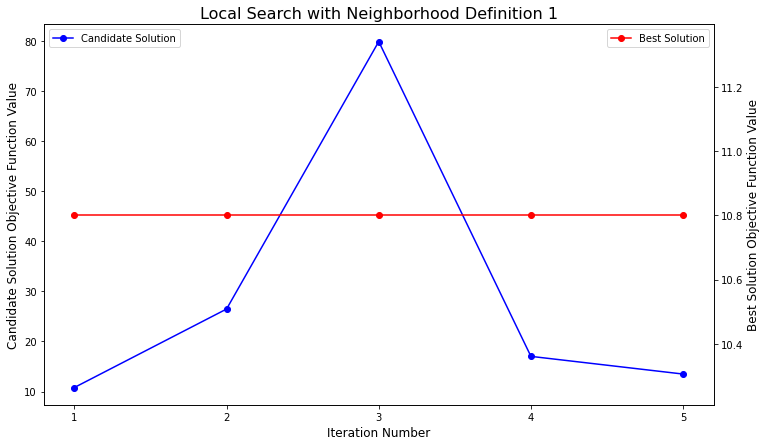

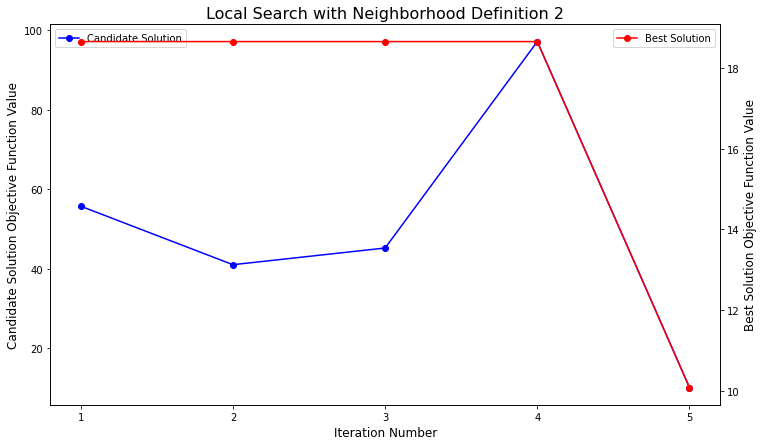

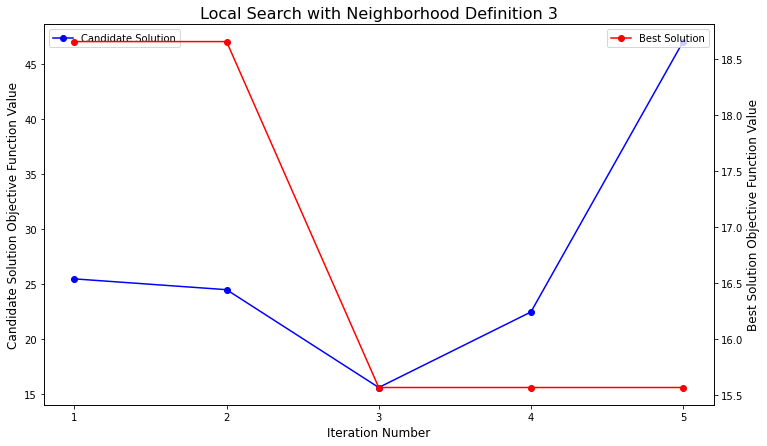

In [49]:
times, objectives, ngh, runs = [], [], [], []
for k in range(1,5):
    for i in range(1, n_run+1):
        print("neighborhood ", k, "run ", i)
        ngh.append(k)
        runs.append(i)
        local_search_average = LocalSearch(rg_, init_sol, n_iteration, wt_obj='average')
        local_search_average.run(which_neighbor=k)
        times.append(local_search_average.time)
        objectives.append(local_search_average.best_value)
        local_search_average.plot_ls(k, which_run=i)

In [ ]:
Res = pd.DataFrame(columns=['Neighborhood','Run_n','BestObj','Time'])
Res['Neighborhood'] = ngh
Res['Run_n'] = runs
Res['BestObj'] = objectives
Res['Time'] = times
Res.to_excel("excel_files/local_search_w_different_ngh.xlsx")

## 2. SA with selected neighborhood

In [ ]:
selected_neighborhood = 1 # later to be changed

In [ ]:
times, objectives, runs = [], [], []
for i in range(1, n_run+1):
    print("run ", i)
    runs.append(i)
    simulated_annealing_average = SimulatedAnnealing(rg_, init_sol, n_iteration, "average")
    simulated_annealing_average.run(which_neighbor=selected_neighborhood)
    times.append(simulated_annealing_average.time)
    objectives.append(simulated_annealing_average.best_value)
    simulated_annealing_average.plot_sa(selected_neighborhood, which_run=i)

In [ ]:
Res = pd.DataFrame(columns=['Run_n','BestObj','Time'])
Res['Run_n'] = runs
Res['BestObj'] = objectives
Res['Time'] = times
Res.to_excel("excel_files/simulated_annealing_w_selected_ngh.xlsx")

## 3. VNS

In [ ]:
times, objectives, runs = [], [], []
for i in range(1, n_run+1):
    print("run ", i)
    runs.append(i)
    vns_average = VNS(rg_, init_sol, n_iteration, "average")
    vns_average.run()
    times.append(vns_average.time)
    objectives.append(vns_average.best_value)
    vns_average.plot_vns(which_run=i)

In [ ]:
Res = pd.DataFrame(columns=['Run_n','BestObj','Time'])
Res['Run_n'] = runs
Res['BestObj'] = objectives
Res['Time'] = times
Res.to_excel("excel_files/vns.xlsx")

## 4. Local Search with Random Initial Solution

In [ ]:
init_sol = getRandomFeasibleSolution("average")

In [ ]:
times, objectives, runs = [], [], []
for i in range(1, n_run+1):
    print("run ", i)
    runs.append(i)
    local_search_average = LocalSearch(rg_, init_sol, n_iteration, wt_obj='average')
    local_search_average.run(which_neighbor=selected_neighborhood)
    times.append(local_search_average.time)
    objectives.append(local_search_average.best_value)
    local_search_average.plot_ls(selected_neighborhood, which_run=i, randomm_init_sol=True)

In [ ]:
Res = pd.DataFrame(columns=['Run_n','BestObj','Time'])
Res['Run_n'] = runs
Res['BestObj'] = objectives
Res['Time'] = times
Res.to_excel("excel_files/rnd_local_search_w_selected_ngh.xlsx")

## 5. Simulated Annealing with Random Initial Solution

In [ ]:
times, objectives, runs = [], [], []
for i in range(1, n_run+1):
    print("run ", i)
    runs.append(i)
    simulated_annealing_average = SimulatedAnnealing(rg_, init_sol, n_iteration, "average")
    simulated_annealing_average.run(which_neighbor=selected_neighborhood)
    times.append(simulated_annealing_average.time)
    objectives.append(simulated_annealing_average.best_value)
    simulated_annealing_average.plot_sa(selected_neighborhood, which_run=i, randomm_init_sol=True)

In [ ]:
Res = pd.DataFrame(columns=['Run_n','BestObj','Time'])
Res['Run_n'] = runs
Res['BestObj'] = objectives
Res['Time'] = times
Res.to_excel("excel_files/rnd_simulated_annealing_w_selected_ngh.xlsx")

## 6. VNS with Random Initial Solution

In [ ]:
times, objectives, runs = [], [], []
for i in range(1, n_run+1):
    print("run ", i)
    runs.append(i)
    vns_average = VNS(rg_, init_sol, n_iteration, "average")
    vns_average.run()
    times.append(vns_average.time)
    objectives.append(vns_average.best_value)
    vns_average.plot_vns(which_run=i, randomm_init_sol=True)

In [ ]:
Res = pd.DataFrame(columns=['Run_n','BestObj','Time'])
Res['Run_n'] = runs
Res['BestObj'] = objectives
Res['Time'] = times
Res.to_excel("excel_files/rnd_vns.xlsx")

## 7. Multi-Objective Local Search & VNS

In [ ]:
init_sol = constructionHeuristic("average")

In [ ]:
times_LS, times_VNS, SM_LS, SM_VNS, Dm_LS, Dm_VNS, QM_LS, QM_VNS, runs = [], [], [], [], [], [], [],[],[]
for i in range(1, n_run+1):
    print("run ", i)
    runs.append(i)
    
    local_search_multi = LocalSearchMultiObj(rg_, init_sol, n_iteration,wt_obj="average")
    local_search_multi.run(which_neighbor=selected_neighborhood)
    times_LS.append(local_search_multi.time)
    sm_, dm_ = SM_DM(local_search_multi)
    SM_LS.append(sm_)
    Dm_LS.append(dm_)
    
    vns_multi = VNSMultiObj(rg_, init_sol, n_iteration,wt_obj="average")
    vns_multi.run()
    times_VNS.append(local_search_multi.time)
    sm_, dm_ = SM_DM(vns_multi)
    SM_VNS.append(sm_)
    Dm_VNS.append(dm_)
    
    ls_QM, vns_QM = QM(local_search_multi,vns_multi)
    QM_LS.append(ls_QM)
    QM_VNS.append(vns_QM)
    
    local_search_multi.plot(which_neighbor=selected_neighborhood, which_run=i)
    vns_multi.plot(which_run=i)

In [ ]:
Res = pd.DataFrame(columns=['Run_n','LS_SM','LS_DM','LS_QM','LS_Time','VNS_SM','VNS_DM','VNS_QM','VNS_Time'])
Res['Run_n'] = runs
Res['LS_SM'] = SM_LS
Res['LS_DM'] = Dm_LS
Res['LS_QM'] = QM_LS
Res['LS_Time'] = times_LS
Res['VNS_SM'] = SM_VNS
Res['VNS_DM'] = Dm_VNS
Res['VNS_QM'] = QM_VNS
Res['VNS_Time'] = times_VNS
Res.to_excel("excel_files/multiobjective.xlsx")